In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from nplinker_constants import nplinker_setup
nplinker_setup(LDA_PATH='/Users/simon/git/lda/code')

In [3]:
from metabolomics import load_spectra
mgf_file = '/srv/data/crusemann/gnps/METABOLOMICS-SNETS-c36f90ba-download_clustered_spectra-main.mgf'
mgf_file = '/Volumes/FIDELE/gnps/METABOLOMICS-SNETS-c36f90ba-download_clustered_spectra-main.mgf'
spectra = load_spectra(mgf_file)

Loaded 5930 molecules


In [4]:
nodes_file = '/srv/data/crusemann/gnps/0d51c5b6c73b489185a5503d319977ab..out'
nodes_file = '/Volumes/FIDELE/gnps/0d51c5b6c73b489185a5503d319977ab..out'

In [5]:
from metabolomics import load_metadata
load_metadata(spectra,nodes_file)

In [6]:
for s in spectra:
    if len(s.annotations) > 0:
        print(s.annotations)



[('Sorbitane Monopalmitate - Polysorbate 40 in-source fragment', 'gnps')]
[('Massbank:FFF00078 Stigmastanol', 'gnps')]
[('Sorbitane Monopalmitate - Polysorbate 40 in-source fragment', 'gnps')]
[('Massbank:FFF00098 24-Ethylcoprostanol', 'gnps')]
[('Sorbitane Monopalmitate - Polysorbate 40 in-source fragment', 'gnps')]
[('Sorbitane Monopalmitate - Polysorbate 40 in-source fragment', 'gnps')]
[('Sorbitane Monopalmitate - Polysorbate 40 in-source fragment', 'gnps')]
[('(2R,3R,4S,6R)-2-((10-hydroxy-2,2-dimethyl-3,4-dihydro-2H-benzo[g]chromen-5-yl)oxy)-6-(hydroxymethyl)tetrahydro-2H-pyran-3,4,5-triol', 'gnps')]
[('MLS001060855-01!', 'gnps')]
[('Massbank:CE000164 S,R-Noscapine', 'gnps')]
[('MLS000876958-01!2-(3,4-dimethoxyphenyl)-5-hydroxy-3,6,7,8-tetramethoxychromen-4-one', 'gnps')]
[('Sevadicin', 'gnps')]
[('MLS000830274-01!Ethmozine', 'gnps')]
[('8-desoxyenterocin', 'gnps')]
[('Sorbitane Monostearate - Polysorbate 60 in-source fragment', 'gnps')]
[('Sorbitane Monostearate - Polysorbate 60 

In [7]:
from metabolomics import load_edges
edge_file = '/srv/data/crusemann/gnps/9a93d720f69143bb9f971db39b5d2ba2.pairsinfo'
edge_file = '/Volumes/FIDELE/gnps/9a93d720f69143bb9f971db39b5d2ba2.pairsinfo'
load_edges(spectra,edge_file)
from metabolomics import make_families
families = make_families(spectra)

In [66]:
import os,glob
from genomics import loadBGC_from_cluster_files,make_mibig_bgc_dict
mibig_json_dir = '/Volumes/FIDELE/mibig/mibig_json_1.4/'
mibig_bgc_dict = make_mibig_bgc_dict(mibig_json_dir)

input_files = []
ann_files = []
# this is really messy - change folders to change which folers are included
# we make two lists of files - the clustering ones and the annotation ones
# clusterin gives us the mol families, networking the metadata (bigscape class etc)
# it's also really slow, because of the antismash file matching....which is a mess
# it works for this data but is incredibly non robust
root_path = '/srv/data/crusemann/bigscape/bigscape_corason_crusemann_complete_annotated_mibigs_mix_automode_20180713/network_files/2018-07-13_16-34-11_hybrids_auto_crusemann_bgcs_automode_mix_mibig'
root_path = '/Volumes/FIDELE/bigscape_corason_crusemann_complete_annotated_mibigs_mix_automode_20180713/network_files/2018-07-13_16-34-11_hybrids_auto_crusemann_bgcs_automode_mix_mibig'
folders = ['NRPS','Others','PKSI','PKS-NRP_Hybrids','PKSother','RiPPs','Saccharides','Terpene']

# ditched 'mix'
for folder in folders:
    fam_file = os.path.join(root_path,folder)
    cluster_file = glob.glob(fam_file + os.sep + folder + "_clustering*")
    annotation_files = glob.glob(fam_file + os.sep + "Network_*")
    input_files.append(cluster_file[0])
    ann_files.append(annotation_files[0])
    antismash_dir = '/srv/data/crusemann/antismash/justin-20181022/'
    antismash_dir = '/Volumes/FIDELE/justin-20181022/'
gcf_list,bgc_list, strain_list = loadBGC_from_cluster_files(input_files,ann_files,antismash_dir=antismash_dir,antismash_format = 'flat',mibig_bgc_dict = mibig_bgc_dict)

Found 1816 MiBIG json files


Next cell adds a random object to each spectrum and gcf object, for doing the permutation testing

In [139]:
# count how many times each strain appears in a spectra
strain_counts = {s:0 for s in strain_list}
total = 0
for s in spectra:
    for st in strain_counts:
        if s.has_strain(st):
            strain_counts[st] += 1
            total += 1
strain_prob_dict = {s:v/total for s,v in strain_counts.items()}

In [140]:
# initiate the random ones
for g in gcf_list:
    g.add_random(bgc_list)
for s in spectra:
    s.add_random(strain_prob_dict)

ValueError: a must be 1-dimensional or an integer

In [ ]:
from scoring import compute_all_scores,metcalf_scoring
m_scores = compute_all_scores(spectra,gcf_list,strain_list,metcalf_scoring,do_random = True)

In [68]:
gcf_with_mibig = []
for gcf in gcf_list:
    if len(gcf.get_mibig_bgcs()) > 0:
        gcf_with_mibig.append(gcf)
print(len(gcf_with_mibig),len(gcf_list))

43 1574


In [69]:
spectra_with_lib = []
for s in spectra:
    if len(s.annotations) > 0:
        spectra_with_lib.append(s)
print(len(spectra_with_lib))

109


In [70]:
from genomics import load_mibig_map
mibig_map = load_mibig_map()


In [71]:
name_scores = {}
from scoring import name_scoring,compute_all_scores,metcalf_scoring
name_scores = compute_all_scores(spectra_with_lib,gcf_with_mibig,mibig_map,name_scoring,do_random = False)
for s in spectra_with_lib:
    for g in gcf_with_mibig:
        if name_scores[s][g][0] > 0:
            print(s,g,name_scores[s][g])
            sc,m = metcalf_scoring(s,g,strain_list)
            print( len(g.random_gcf.strain_set),len(s.random_spectrum.strain_set),sc)
            for st in m:
                print( st.name)

Done 0 of 109
Staurosporine Staurosporine M+H
Staurosporine Staurosporine M+H
Done 100 of 109
Spectrum 41296 with 16 peaks, max_ms2_intensity 66689.96875 <genomics.GCF object at 0x1151520b8> (100, None, ('Staurosporine', 'Staurosporine M+H'))
34 51 90
CNX814
CNS296
CNY231
CNP193
CNY694
CNH718
CNB458
CNS744
CNS991
CNP105
CNT005
CNY260
CNS342
CNT088
CNS325
CNT849
CNS673
CNR107
CNY280
CNY256
CNS051
CNH962
CNH877
CNT798
CNY282
CNY234
CNY011
CNQ884
CNY281
CNR921
CNY237
Spectrum 41297 with 32 peaks, max_ms2_intensity 7503.780762 <genomics.GCF object at 0x1151520b8> (100, None, ('Staurosporine', 'Staurosporine M+H'))
34 18 69
CNB458
CNY260
CNS296
CNY282
CNT849
CNR107
CNR921
CNS991


In [74]:
from scoring import knownclusterblast_scoring
kcb_scores = compute_all_scores(spectra_with_lib,gcf_list,mibig_map,knownclusterblast_scoring,do_random = False)

Done 0 of 109
No antismash file in BGC0001237(None)
No antismash file in BGC0000145(None)
No antismash file in BGC0000432(None)
No antismash file in BGC0000958(None)
No antismash file in BGC0001216(None)
No antismash file in BGC0000150(None)
No antismash file in BGC0000333(None)
No antismash file in BGC0001041(None)
No antismash file in BGC0000652(None)
No antismash file in BGC0000033(None)
No antismash file in BGC0000717(None)
No antismash file in BGC0000827(None)
No antismash file in BGC0001221(None)
No antismash file in BGC0001083(None)
No antismash file in BGC0000706(None)
No antismash file in BGC0001079(None)
No antismash file in BGC0001283(None)
No antismash file in BGC0001007(None)
No antismash file in BGC0000142(None)
No antismash file in BGC0000137(None)
No antismash file in BGC0001006(None)
No antismash file in BGC0001303(None)
No antismash file in BGC0000028(None)
No antismash file in BGC0001232(None)
No antismash file in BGC0001348(None)
No antismash file in BGC0001077(None

Done 100 of 109


In [88]:
for s in spectra_with_lib:
    if ('Enterocin','gnps') in s.annotations:
        print(s.spectrum_id)
        found = s
ggg = []
for g,score_tuple in kcb_scores[found].items():

    if score_tuple[0] and score_tuple[0] > 0:
        ggg.append(g)
        print(metcalf_scoring(s,g,strain_list),score_tuple,len(g.bgc_list),len(s.random_spectrum.strain_set))
        for b in g.bgc_list:
            print(b.metadata['knownclusterblast'])

36184
(132, set()) (95, None, ('Enterocin', 'Enterocin M+H')) 1 1
[('BGC0000220_c1', '95'), ('BGC0000225_c1', '30'), ('BGC0000233_c1', '30'), ('BGC0000222_c1', '30'), ('BGC0000212_c1', '25'), ('BGC0000242_c1', '25'), ('BGC0000194_c1', '15'), ('BGC0000228_c1', '15'), ('BGC0000227_c1', '15'), ('BGC0000195_c1', '20')]
(131, set()) (125, None, ('Enterocin', 'Enterocin M+H')) 2 1
[('BGC0000220_c1', '65'), ('BGC0000212_c1', '20'), ('BGC0000194_c1', '15'), ('BGC0000228_c1', '15'), ('BGC0000227_c1', '15'), ('BGC0001409_c1', '15'), ('BGC0000225_c1', '20'), ('BGC0001074_c1', '20'), ('BGC0000254_c1', '20'), ('BGC0000209_c1', '20')]
[('BGC0000220_c1', '60'), ('BGC0000212_c1', '20'), ('BGC0000194_c1', '15'), ('BGC0000228_c1', '15'), ('BGC0000227_c1', '15'), ('BGC0001409_c1', '15'), ('BGC0001074_c1', '20'), ('BGC0000254_c1', '20'), ('BGC0000209_c1', '20'), ('BGC0000208_c1', '20')]


In [90]:
from genomics import load_mibig_library_json
mibig = load_mibig_library_json('/srv/data/mibig/mibig_json_1.4')

Found 0 MiBIG json files


In [100]:
for f in families:
    if found in f.spectra:
        family_found = f
print(family_found)
m = metcalf_scoring(family_found,ggg[0],strain_list)
print(m)

Molecular family with 4 spectra
(153, {<genomics.Strain object at 0x113dfb390>})


In [108]:
randoms = []
reals = []
for g in gcf_list:
    randoms.append(metcalf_scoring(family_found,g.random_gcf,strain_list))
    reals.append(metcalf_scoring(family_found,g,strain_list))

0.0071


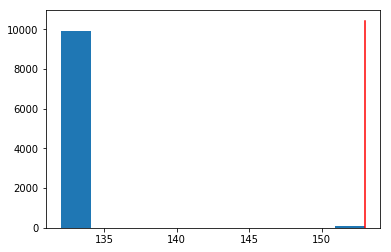

In [123]:
import pylab as plt
%matplotlib inline
r = [a[0] for a in randoms]
plt.hist(r)
plt.plot([m[0],m[0]],plt.ylim(),'r')
p_value = sum((a >= m[0] for a in r))
p_value/=len(r)
print(p_value)

0.0019059720457433292


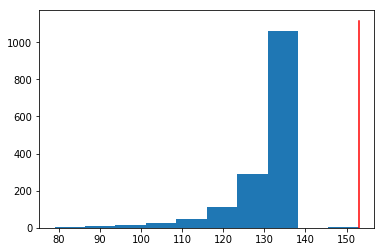

In [114]:
rr = [a[0] for a in reals]
plt.hist(rr)
plt.plot([m[0],m[0]],plt.ylim(),'r')
p_value = sum((a >= m[0] for a in r))
p_value/=len(r)
print(p_value)

In [122]:
randoms = []
for i in range(10000):
    ggg[0].add_random(strain_list)
    randoms.append(metcalf_scoring(family_found,ggg[0].random_gcf,strain_list))

In [124]:
print(len(ggg[0].random_gcf.strain_set))

1


In [87]:
print(family_found.spectra)

[<metabolomics.Spectrum object at 0x112e3c128>, <metabolomics.Spectrum object at 0x112eb0da0>, <metabolomics.Spectrum object at 0x112eb0f60>, <metabolomics.Spectrum object at 0x112ee4e10>]


In [ ]:
import pylab as plt
import numpy as np
%matplotlib inline
scores =[]
random_scores = []
for s,g in m_scores.items():
    for gg,sc in g.items():
        random_scores.append(sc[1])
        scores.append(sc[0])
plt.hist(random_scores,bins=50)
plt.xlim([100,150])
plt.figure()
plt.hist(scores,bins=50)
plt.xlim([100,150])
plt.ylim([0,1000])
random_scores.sort()
perc99 = random_scores[int(np.floor(0.99*len(random_scores)))]
print perc99
scores = np.array(scores)
n_above = len(np.where(scores>=perc99)[0])
print (1.0*n_above)/len(scores)

In [ ]:
best_spec = None
best_gcf = None
for spectrum in m_scores:
    for gcf in m_scores[spectrum]:
        if m_scores[spectrum][gcf] == best:
            best_spec = spectrum
            best_gcf = gcf

In [ ]:
print best_spec
print best_gcf
for strain in strain_list:
    print strain,best_spec.has_strain(strain),best_gcf.has_strain(strain)

In [ ]:
print best_spec.metadata['LibraryID']
for bgc in best_gcf.bgc_list:
    print bgc,bgc.bigscape_class,bgc.product_prediction

In [ ]:
link_file = 'mibig_gnps_links_q3_loose.csv'
links = []
import csv
with open(link_file,'r') as f:
    reader = csv.reader(f)
    heads = reader.next()
    print heads
    for line in reader:
        links.append(line)

In [ ]:
link_dict = {}
for link in links:
    short_gnps_name = link[3].split()[0]
    link_dict[short_gnps_name] = link[0]    

In [ ]:
spec_lib_dict = {}
for spectrum in spectra:
    if spectrum.spectrum_id == '125':
        print "Hello"
    if spectrum.metadata['LibraryID']:
        lid = spectrum.metadata['LibraryID'].split()[0]
        if lid in link_dict:
            spec_lib_dict[spectrum] = lid

In [ ]:
for spec in spec_lib_dict:
    bgc_name = link_dict[spec_lib_dict[spec]]
    print bgc_name
    bgc = [b for b in bgc_list if b.name.startswith(bgc_name)]
    print bgc

In [ ]:
print [b.name for b in bgc_list if b.name.startswith('BGC')]

In [ ]:
for b in bgc_list:
    if hasattr(b,'metadata'):
        kcb = b.metadata.get('knownclusterblast',None)
        if kcb:
            print kcb
            break

In [ ]:
for s in kcb_scores:
    for g in kcb_scores[s]:
        sc,_,metadata = kcb_scores[s][g]
        if sc > 0:
            a,_ = metcalf_scoring(s,g,strain_list)
            print sc,metadata,a

In [ ]:
for f in families:
    for s in f.spectra:
        if s.spectrum_id == '95':
            found = f

In [ ]:
for s in found.spectra:
    print s.metadata['LibraryID']

In [ ]:
from genomics import load_mibig_library_json
mibig = load_mibig_library_json('/srv/data/mibig/mibig_json_1.4')
mibig_compound_dict = {}
for b in mibig:
    compound = mibig[b]['general_params']['compounds'][0]['compound']
    mibig_compound_dict[compound] = b
print mibig[b].keys()
compounds = []
for s in spectra:
    if len(s.annotations) > 0:
        for compound,_ in s.annotations:
            compounds.append(compound)
compounds = set(compounds)
for c in compounds:
    if 'derep' in c:
        initial = c.split(';')[0].split('_')[0].lower()
        for co in mibig_compound_dict:
            if initial in co:
                print co,initial,c
        